# Credit Risk Analysis with Machine Learning



### Predicting the risk of client default using XGBoost, LightGBM and CatBoost



---


**Credit risk** is associated with the possibility of a client failing to meet contractual obligations, such as mortgages, credit card debts, and other types of loans.

Minimizing the risk of default is a major concern for financial institutions. For this reason, commercial and investment banks, venture capital funds, asset management companies and insurance firms, to name a few, are increasingly relying on technology to predict which clients are more prone to not honoring their debts.

**Machine Learning** models have been helping these companies to improve the accuracy of their credit risk analysis, providing a scientific method to identify potential debtors in advance.




In [1]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 54 kB/s 


In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# set the aesthetic style of the plots
sns.set_style()

# filter warning messages
import warnings
warnings.filterwarnings('ignore')

In [3]:
# set default matplotlib parameters
COLOR = '#ababab'
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['grid.color'] = COLOR
mpl.rcParams['grid.alpha'] = 0.1

In [4]:
# import data set and create a data frame
df_credit = pd.read_csv('/content/finalmerged.csv')

In [5]:
# show first 5 rows
df_credit.head()

,Unnamed: 0,customerid,longitude_gps,latitude_gps,bank_branch_clients,loannumber,loanamount,totaldue,termdays,good_bad_flag,...,employment_status_client_Permanent,employment_status_client_Retired,employment_status_client_Self-Employed,employment_status_client_Student,employment_status_client_Unemployed,employment_status_client_Unknown,is_late_for_firstpay,month_approved_loan,exceeds_loan_term_days,TipoInteres
0,0,8a858e135cb22031015cbafc76964ebd,3.319219,6.528604,0,2,10000.0,13000.0,30,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,June,1.0,1.0
1,1,8a858e275c7ea5ec015c82482d7c3996,3.325598,7.119403,0,2,10000.0,13000.0,30,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,June,1.0,1.0
2,2,8a858e5b5bd99460015bdc95cd485634,5.746100,5.563174,0,4,10000.0,13000.0,30,1,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,June,1.0,1.0
3,3,8a858e5b5bd99460015bdc95cd485634,5.746100,5.563174,0,4,10000.0,13000.0,30,1,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,May,1.0,1.0
4,4,8a858e5b5bd99460015bdc95cd485634,5.746100,5.563174,0,4,10000.0,13000.0,30,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,May,0.0,1.0


## Data Analysis

In [6]:
# data frame shape
print('Number of rows: ', df_credit.shape[0])
print('Number of columns: ', df_credit.shape[1])

Number of rows:  13698
Number of columns:  50


We are working with a data set containing 50 features for 13698 clients. `good_bad_flag` is a binary feature and is the target variable we are trying to predict. We'll explore all features searching for outliers, treating possible missing values, and making other necessary adjustments to improve the overall quality of the model.

Let's examine the structure of the data set.

In [7]:
# data frame summary
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13698 entries, 0 to 13697
Data columns (total 50 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Unnamed: 0                                13698 non-null  int64  
 1   customerid                                13698 non-null  object 
 2   longitude_gps                             13698 non-null  float64
 3   latitude_gps                              13698 non-null  float64
 4   bank_branch_clients                       13698 non-null  int64  
 5   loannumber                                13698 non-null  int64  
 6   loanamount                                13698 non-null  float64
 7   totaldue                                  13698 non-null  float64
 8   termdays                                  13698 non-null  int64  
 9   good_bad_flag                             13698 non-null  int64  
 10  referred                          

We can see that some features have missing values. Let's take a closer look at them.

In [8]:
# percentage of missing values per feature
print((df_credit.isnull().sum() * 100 / df_credit.shape[0]).sort_values(ascending=False))

TipoInteres                                 0.036502
exceeds_loan_term_days                      0.036502
month_approved_loan                         0.036502
is_late_for_firstpay                        0.036502
bank_name_client_Unity Bank                 0.000000
bank_name_client_GT Bank                    0.000000
bank_name_client_Heritage Bank              0.000000
bank_name_client_Keystone Bank              0.000000
bank_name_client_Skye Bank                  0.000000
bank_name_client_Stanbic IBTC               0.000000
bank_name_client_Standard Chartered         0.000000
bank_name_client_Sterling Bank              0.000000
bank_name_client_UBA                        0.000000
bank_name_client_Union Bank                 0.000000
bank_name_client_Zenith Bank                0.000000
bank_name_client_Wema Bank                  0.000000
customerid                                  0.000000
employment_status_client_Contract           0.000000
employment_status_client_Permanent          0.

In [11]:
df_credit = df_credit.loc[:, ~df_credit.columns.str.contains('^Unnamed')]

Ok, now we are working with a leaner data set. Before dealing with the missing values, let's examine if there are outliers in the data set. We'll start by taking a look at some statistical details of the numerical features.

In [12]:
# show descriptive statistics
df_credit.describe()

,longitude_gps,latitude_gps,bank_branch_clients,loannumber,loanamount,totaldue,termdays,good_bad_flag,referred,realage,...,employment_status_client_Contract,employment_status_client_Permanent,employment_status_client_Retired,employment_status_client_Self-Employed,employment_status_client_Student,employment_status_client_Unemployed,employment_status_client_Unknown,is_late_for_firstpay,exceeds_loan_term_days,TipoInteres
count,13698.000000,13698.000000,13698.000000,13698.00000,13698.000000,13698.000000,13698.000000,13698.000000,13698.000000,13698.000000,...,13698.00000,13698.000000,13698.000000,13698.000000,13698.000000,13698.000000,13698.000000,13693.000000,13693.000000,13693.000000
mean,4.481972,7.291344,0.007811,8.39889,25684.771499,29808.628435,33.233684,0.815302,0.058549,37.217623,...,0.00073,0.667470,0.002117,0.169295,0.044897,0.015988,0.099504,0.357628,0.292923,0.809740
std,8.638033,3.435619,0.088039,4.31954,12625.588256,13773.285101,14.440577,0.388067,0.234787,6.155633,...,0.02701,0.471137,0.045965,0.375026,0.207086,0.125432,0.299348,0.479319,0.455120,0.237811
min,-118.247009,-33.868818,0.000000,2.00000,10000.000000,10000.000000,15.000000,0.000000,0.000000,26.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.354793,6.471885,0.000000,5.00000,10000.000000,13000.000000,30.000000,1.000000,0.000000,33.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.633333
50%,3.576022,6.617633,0.000000,8.00000,30000.000000,33000.000000,30.000000,1.000000,0.000000,37.000000,...,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,6.364658,7.421333,0.000000,11.00000,40000.000000,44000.000000,30.000000,1.000000,0.000000,41.000000,...,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,151.209290,71.228069,1.000000,27.00000,60000.000000,68100.000000,90.000000,1.000000,1.000000,60.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


A new data frame, containing numerical features of interest, will be created. Plotting a histogram for these features will helps us examine their distribution.

In [14]:
# data frame containing numerical features
df_credit_numerical = df_credit[['longitude_gps', 'latitude_gps', 
                                 'loannumber', 'loanamount', 'totaldue', 'termdays', 
                                 'realage', 'TipoInteres']]

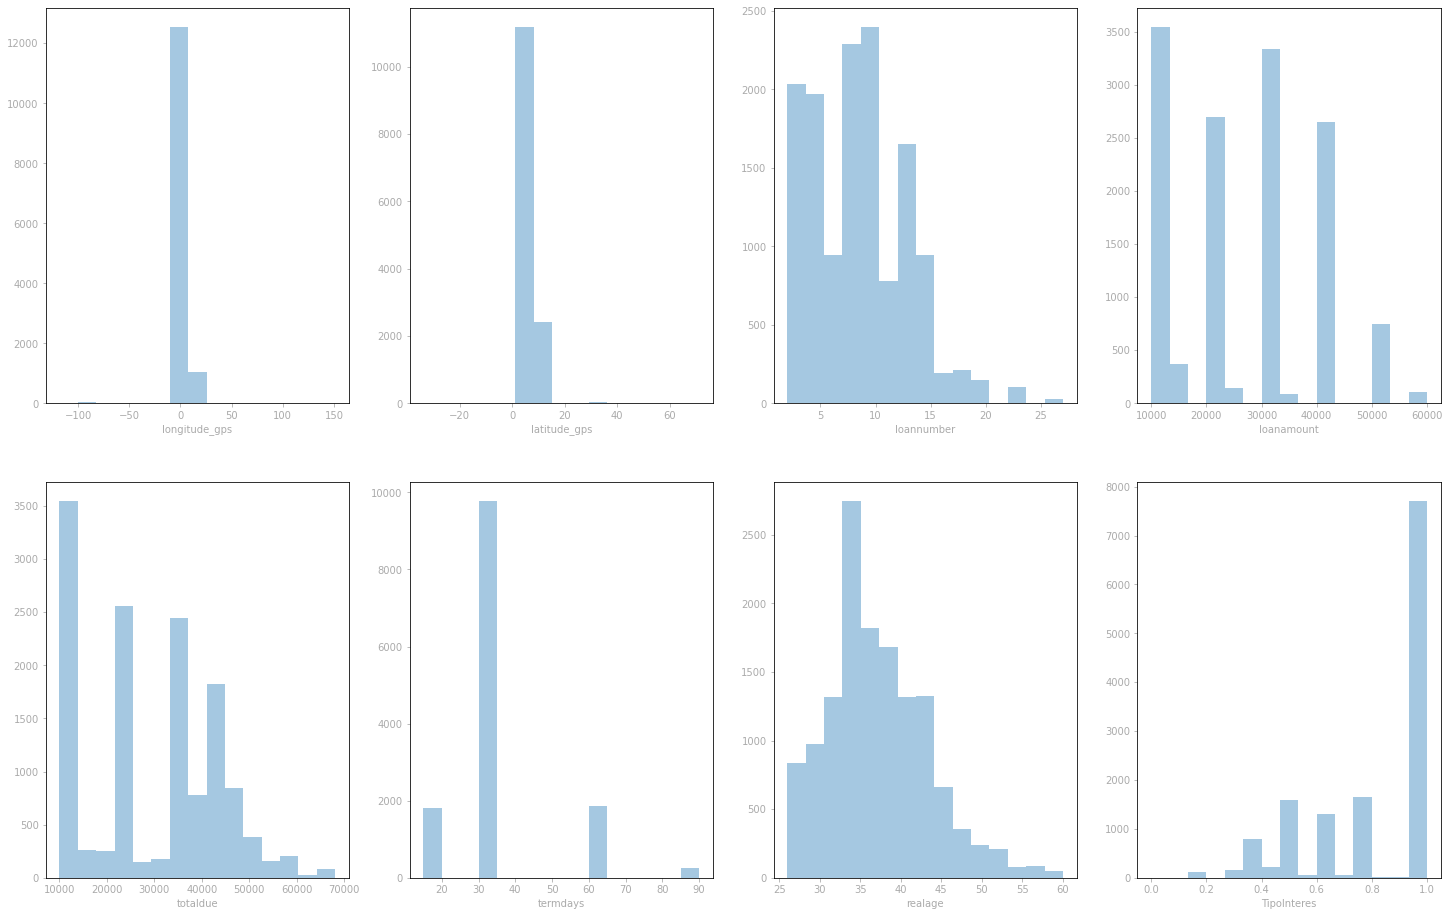

In [16]:
# plot a histogram for each of the features above 

nrows = 2
ncols = 4

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 16))

r = 0
c = 0

for i in df_credit_numerical:
  sns.distplot(df_credit_numerical[i], bins=15,kde=False, ax=ax[r][c])
  if c == ncols - 1:
    r += 1
    c = 0
  else:
    c += 1

plt.show()

In [17]:
df_credit.isnull().sum()

customerid                                  0
longitude_gps                               0
latitude_gps                                0
bank_branch_clients                         0
loannumber                                  0
loanamount                                  0
totaldue                                    0
termdays                                    0
good_bad_flag                               0
referred                                    0
realage                                     0
TipoInteresAhora                            0
bank_account_Current                        0
bank_account_Other                          0
bank_account_Savings                        0
level_of_education_clients_Graduate         0
level_of_education_clients_Post-Graduate    0
level_of_education_clients_Primary          0
level_of_education_clients_Secondary        0
level_of_education_clients_Unknown          0
bank_name_client_Access Bank                0
bank_name_client_Diamond Bank     

## Machine Learning Models

We are experimenting with the following 3 boosting algorithms to determine which one yields better results:


*   XGBoost
*   LightGBM
*   CatBoost

Before starting with the models, let's split the data into training and test sets.

In [34]:
# feature matrix
X = df_credit.drop(['customerid','good_bad_flag', 'month_approved_loan'], axis=1)

# target vector
y = df_credit['good_bad_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y)

In [39]:
# standardize numerical variables
from imblearn.under_sampling import RandomUnderSampler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# resample
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

We're all set up to start evaluating the models. It's worth mentioning that we should consider `Precision`, `Recall` and `F1 Score` as evaluation metrics, for the following reasons:


*   **Precision** will give us the proportion of positive identifications that were indeed correct. It can be defined as:

${Precision} = \frac{True Positives}{True Positives + False Positives}$


*   **Recall** will determine the proportion of real positives that were 
correctly identified, and it can be defined as:

${Recall} = \frac{True Positives}{True Positives + False Negatives}$

*   **F1 Score** is a metric that is useful when we need to seek a balance between precision and recall. The formula is defined as:

${F_1} = 2 \times \frac{Precision \times Recall}{Precision + Recall}$


Since our objective is to minimize company loss, predicting the risk of client default, a good recall rate is desirable because we want to identify the maximum amount of clients that are indeed prone to stop paying their debts, thus, we are pursuing a small number of *False Negatives*.

Additionally, we also seek to minimize the number of False Positives because we don't want clients to be mistakenly identified as defaulters. Therefore, a good precision rate is also desirable.

However, there is always a tradeoff between precision and recall. For this article, we chose to give more emphasis to recall, using it as our evaluation metric. 

We'll use Cross-Validation to get better results. Instead of simply splitting the data into a train and test set, the cross_validate method splits our training data into k number of Folds, making better use of the data. In our case, we'll perform 5-fold cross-validation, as we let the default k value.

In [22]:
# define the function val_model
def val_model(X, y, clf, show=True):
    """
    Apply cross-validation on the training set.

    # Arguments
        X: DataFrame containing the independent variables.
        y: Series containing the target vector.
        clf: Scikit-learn estimator instance.
        
    # Returns
        float, mean value of the cross-validation scores.
    """
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if show == True:
        print(f'Recall: {scores.mean()}, {scores.std()}')
    
    return scores.mean()

In [40]:
#evaluate the models
xgb = XGBClassifier()
lgb = LGBMClassifier()
cb = CatBoostClassifier()

model = []
recall = []

for clf in (xgb, lgb, cb):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train_rus, y_train_rus, clf, show=False))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

Se han truncado las últimas 5000 líneas del flujo de salida.
4:	learn: 0.6843203	total: 11.7ms	remaining: 2.33s
5:	learn: 0.6829443	total: 13.9ms	remaining: 2.3s
6:	learn: 0.6807236	total: 16.2ms	remaining: 2.29s
7:	learn: 0.6793353	total: 18.5ms	remaining: 2.29s
8:	learn: 0.6778967	total: 20.7ms	remaining: 2.28s
9:	learn: 0.6763894	total: 23.1ms	remaining: 2.29s
10:	learn: 0.6743685	total: 25.4ms	remaining: 2.28s
11:	learn: 0.6733096	total: 27.3ms	remaining: 2.25s
12:	learn: 0.6714600	total: 29.6ms	remaining: 2.25s
13:	learn: 0.6700861	total: 31.8ms	remaining: 2.24s
14:	learn: 0.6689428	total: 34.1ms	remaining: 2.24s
15:	learn: 0.6674965	total: 36.5ms	remaining: 2.24s
16:	learn: 0.6660530	total: 38.9ms	remaining: 2.25s
17:	learn: 0.6649826	total: 41.2ms	remaining: 2.25s
18:	learn: 0.6640065	total: 43.5ms	remaining: 2.25s
19:	learn: 0.6625952	total: 45.8ms	remaining: 2.24s
20:	learn: 0.6605688	total: 48.2ms	remaining: 2.25s
21:	learn: 0.6594730	total: 50.4ms	remaining: 2.24s
22:	learn:

,Recall
XGBClassifier,0.727480
LGBMClassifier,0.834491
CatBoostClassifier,0.825523


Notice that all three models yielded similar results. We'll now tune some hyperparameters on the models to see if we can achieve higher score values. The method utilized here is `GridSearchCV`, which will search over specified parameter values for each estimator.

### XGBoost

Let's start by making some adjustments to the XGBoost estimator. XGBoost is known for being one of the most effective Machine Learning algorithms, due to its good performance on structured and tabular datasets on classification and regression predictive modeling problems. It is highly customizable and counts with a large range of hyperparameters to be tuned.

For the XGBoost model, we'll tune the following hyperparameters, according to [the official documentation](https://xgboost.readthedocs.io/en/latest/parameter.html):


*   `n_estimators` - The number of trees in the model
*   `max_depth` - Maximum depth of a tree
*   `min_child_weight` - Minimum sum of instance weight needed in a child
*   `gamma` - Minimum loss reduction required to make a further partition on a leaf node of the tree
*   `learning_rate` - Step size shrinkage used in the update to prevents overfitting

In [42]:
# XGBoost
xgb = XGBClassifier()

# parameter to be searched
param_grid = {'n_estimators': range(0,1000,50)}

# find the best parameter   
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.8118121796281854 for {'n_estimators': 950}


In [43]:
# XGBoost
xgb = XGBClassifier(n_estimators=50)

# parameter to be searched
param_grid = {'max_depth': [1, 3, 5],
              'min_child_weight': [1, 3, 6]}

# find the best parameter   
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.7464346658134527 for {'max_depth': 5, 'min_child_weight': 3}


In [44]:
# XGBoost
xgb = XGBClassifier(n_estimators=50, max_depth=3, min_child_weight=6)

# parameter to be searched
param_grid = {'gamma': [0, 1, 5]}

# find the best parameter   
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.6942678025076489 for {'gamma': 0}


In [45]:
# XGBoost
xgb = XGBClassifier(n_estimators=50, max_depth=3, min_child_weight=6, gamma=1)

# parameter to be searched
param_grid = {'learning_rate': [0.0001, 0.001, 0.01, 0.1]}

# find the best parameter
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.7333281673898989 for {'learning_rate': 0.001}


### LightGBM

Now, turning to the LightGBM model, another tree-based learning algorithm, we are going to tune the following hyperparameters, referring to the [documentation](https://lightgbm.readthedocs.io/en/latest/Parameters.html):

*   `max_depth` - Maximum depth of a tree
*   `learning_rate` - Shrinkage rate
*   `num_leaves` - Max number of leaves in one tree
*   `min_data_in_leaf` - Minimal number of data in one leaf



In [46]:
# LightGBM
lbg = LGBMClassifier(silent=False)

# parameter to be searched
param_grid = {"max_depth": np.arange(5, 75, 10),
              "learning_rate" : [0.001, 0.01, 0.1],
              "num_leaves": np.arange(20, 220, 50),
             }

# find the best parameter            
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(lbg, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.8555727198192252 for {'learning_rate': 0.1, 'max_depth': 25, 'num_leaves': 120}


In [47]:
lbg = LGBMClassifier(learning_rate=0.01, max_depth=5, num_leaves=50, silent=False)

# parameter to be searched
param_grid = {'min_data_in_leaf': np.arange(100, 1000, 100)}

# find the best parameter            
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(lbg, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.6916123409389353 for {'min_data_in_leaf': 600}


### CatBoost

Lastly, we're going to search over hyperparameter values for CatBoost, our third gradient boosting algorithm. The following hyperparameters will be tuned, according to the [documentation](https://catboost.ai/docs/concepts/parameter-tuning.html):


*   `depth` - Depth of the tree
*   `learning_rate` - As we already know, the learning rate
*   `l2_leaf_reg` - Coefficient at the L2 regularization term of the cost function



In [48]:
# CatBoost
cb = CatBoostClassifier()

# parameter to be searched
param_grid = {'depth': [6, 8, 10],
              'learning_rate': [0.03, 0.1],
              'l2_leaf_reg': [1, 5, 10],
             }

# find the best parameter            
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(cb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

0:	learn: 0.6786559	total: 5.38ms	remaining: 5.37s
1:	learn: 0.6655756	total: 9.75ms	remaining: 4.86s
2:	learn: 0.6583404	total: 14ms	remaining: 4.66s
3:	learn: 0.6401770	total: 18.9ms	remaining: 4.7s
4:	learn: 0.6293535	total: 23.4ms	remaining: 4.65s
5:	learn: 0.6167845	total: 27.8ms	remaining: 4.61s
6:	learn: 0.6024916	total: 32.3ms	remaining: 4.59s
7:	learn: 0.5942617	total: 36.7ms	remaining: 4.55s
8:	learn: 0.5817543	total: 41.3ms	remaining: 4.55s
9:	learn: 0.5739830	total: 45.7ms	remaining: 4.53s
10:	learn: 0.5693389	total: 50ms	remaining: 4.49s
11:	learn: 0.5626319	total: 54.3ms	remaining: 4.47s
12:	learn: 0.5528564	total: 59.1ms	remaining: 4.49s
13:	learn: 0.5415629	total: 64.2ms	remaining: 4.52s
14:	learn: 0.5329251	total: 71.5ms	remaining: 4.69s
15:	learn: 0.5253523	total: 77.8ms	remaining: 4.78s
16:	learn: 0.5158304	total: 83.6ms	remaining: 4.83s
17:	learn: 0.5099163	total: 88.7ms	remaining: 4.84s
18:	learn: 0.5062758	total: 93.4ms	remaining: 4.82s
19:	learn: 0.5009525	total:

After tuning some hyperparameters, all three models displayed betters results. It is worth mentioning that XGBoost presented a great score increase, while LightGBM and CatBoost saw a slight improvement.

Now, we can check how these models perform on the **test set**. To help us visualize the results, we are plotting a **confusion matrix**.

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       633
           1       0.82      1.00      0.90      2792

    accuracy                           0.82      3425
   macro avg       0.41      0.50      0.45      3425
weighted avg       0.66      0.82      0.73      3425



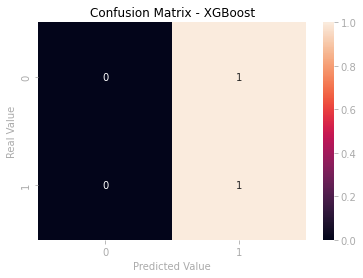

In [52]:
# final XGBoost model
xgb = XGBClassifier(n_estimators=950)
xgb.fit(X_train_rus, y_train_rus)

# prediction
X_test_xgb = scaler.transform(X_test)
y_pred_xgb = xgb.predict(X_test_xgb)

# classification report
print(classification_report(y_test, y_pred_xgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_xgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - XGBoost')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       633
           1       0.82      1.00      0.90      2792

    accuracy                           0.81      3425
   macro avg       0.41      0.50      0.45      3425
weighted avg       0.66      0.81      0.73      3425



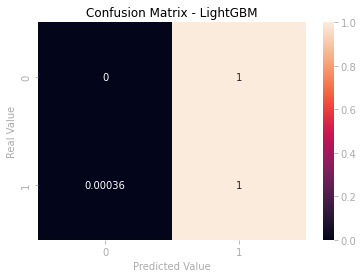

In [51]:
# final LightGBM model
lgb = LGBMClassifier(num_leaves=120, max_depth=25, learning_rate=0.1)
lgb.fit(X_train_rus, y_train_rus)

# prediction
X_test_lgb = scaler.transform(X_test)
y_pred_lgb = lgb.predict(X_test_lgb)

# classification report
print(classification_report(y_test, y_pred_lgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_lgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - LightGBM')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       633
           1       0.82      1.00      0.90      2792

    accuracy                           0.82      3425
   macro avg       0.41      0.50      0.45      3425
weighted avg       0.66      0.82      0.73      3425



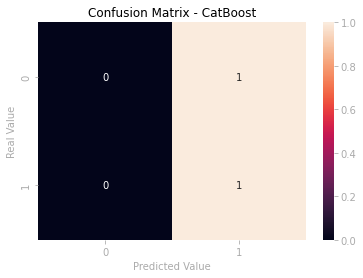

In [50]:
# final CatBoost model
cb = CatBoostClassifier(learning_rate=0.1, depth=8, l2_leaf_reg=5, logging_level='Silent')
cb.fit(X_train_rus, y_train_rus)

# prediction
X_test_cb = scaler.transform(X_test)
y_pred_cb = cb.predict(X_test_cb)

# classification report
print(classification_report(y_test, y_pred_cb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_cb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - CatBoost')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()